In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [3]:
import tensorflow as tf
print("Devices:", tf.config.list_physical_devices())


Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2025-09-05 12:44:39.416935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-09-05 12:44:39.417638: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
import pandas as pd
import time
from sklearn.preprocessing import MinMaxScaler

my_file = "./molecule/acetone.MDE"

df = pd.read_csv(
    my_file,
    sep=r"\s+",
    comment='#',
    names=["Step", "T", "E_KS", "E_tot", "Vol", "P"]
)

print(f"Dimensiunea inițială: {len(df)} rânduri")
print(f"Numărul de step-uri unice: {df['Step'].nunique()}")

# Pentru a păstra toate datele din fiecare step, setează rows_per_group foarte mare
# sau folosește len(df) pentru a fi sigur că iei totul
rows_per_group = len(df)  # sau poți pune 10000 dacă vrei o valoare fixă

# Adauga pozitia in grup in df
df['pos_in_group'] = df.groupby('Step').cumcount()

# Varianta cumcount + mask
start_cumcount = time.time()
mask = df.groupby("Step").cumcount().between(1, rows_per_group)
df_data = df[mask].copy()
df_data['pos_in_group'] = df.loc[mask, 'pos_in_group']
time_cumcount = time.time() - start_cumcount

# Sortare dupa Step si pos_in_group
df_data = df_data.sort_values(['Step', 'pos_in_group']).reset_index(drop=True)

print(f"Dimensiunea după filtrare: {len(df_data)} randuri")
print(f"Range E_tot: [{df_data['E_tot'].min():.6f}, {df_data['E_tot'].max():.6f}] eV")

# Scaleaza energia
scaler = MinMaxScaler()
df_data['Energy_scaled'] = scaler.fit_transform(df_data[['E_tot']])

# Valori originale
print("\nPrimele 10 valori originale E_tot si scalate Energy_scaled:")
print(df_data[['E_tot', 'Energy_scaled']].head(10))

print(f"Timp varianta cumcount: {time_cumcount:.4f} secunde")

Dimensiunea inițială: 6251 rânduri
Numărul de step-uri unice: 1
Dimensiunea după filtrare: 6250 randuri
Range E_tot: [-1029.579540, -1029.408550] eV

Primele 10 valori originale E_tot si scalate Energy_scaled:
        E_tot  Energy_scaled
0 -1029.40857       0.999883
1 -1029.40857       0.999883
2 -1029.40857       0.999883
3 -1029.40857       0.999883
4 -1029.40857       0.999883
5 -1029.40858       0.999825
6 -1029.40858       0.999825
7 -1029.40858       0.999825
8 -1029.40858       0.999825
9 -1029.40858       0.999825
Timp varianta cumcount: 0.0012 secunde


In [13]:
# ## 2. Preprocesare

# %%
# Selectare doar coloanele necesare
features = ['T', 'E_tot', 'Vol', 'P']  # Features pentru predictie
target = 'E_KS'                        # Target

# Extrage datele
X_data = df_data[features].values
y_data = df_data[target].values

print(f"Shape features: {X_data.shape}")
print(f"Shape target: {y_data.shape}")

# Scalare
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data.reshape(-1, 1)).flatten()

print("Scalare completa")

Shape features: (6250, 4)
Shape target: (6250,)
Scalare completa


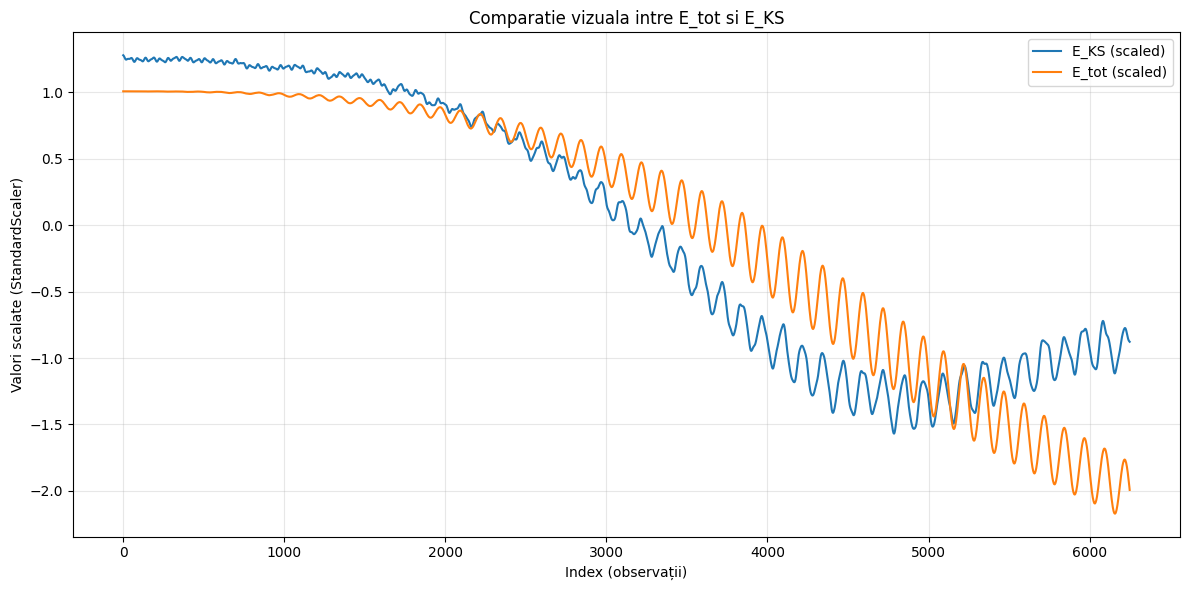

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(range(len(y_scaled)), y_scaled, label='E_KS (scaled)')  # y_scaled = E_KS
plt.plot(range(len(X_scaled)), X_scaled[:,1], label='E_tot (scaled)')  # X_scaled[:,1] = E_tot

plt.xlabel("Index (observații)")
plt.ylabel("Valori scalate (StandardScaler)")
plt.title("Comparatie vizuala intre E_tot si E_KS")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

def create_sequences_multi_step(X, y, sequence_length, out_steps):
    X_sequences = []
    y_sequences = []

    total_samples = len(X)

    # mergem pana la punctul unde mai putem lua o fereastra completa
    last_start = total_samples - sequence_length - out_steps + 1

    for start_idx in range(last_start):
        end_idx = start_idx + sequence_length              # capatul ferestrei de intrare
        out_end_idx = end_idx + out_steps                  # capatul ferestrei de iesire

        X_window = X[start_idx:end_idx]                    # input: secventa din trecut
        y_window = y[end_idx:out_end_idx]                  # output: secventa din viitor

        X_sequences.append(X_window)
        y_sequences.append(y_window)

    return np.array(X_sequences), np.array(y_sequences)

# # Parametri
data_size = len(df_data)
if data_size < 10000:
    SEQUENCE_LENGTH = 50 
    OUT_STEPS = 5
    print(f"Small dataset detected ({data_size} lines)")
    print(f"New parameters: SEQUENCE_LENGTH={SEQUENCE_LENGTH}, OUT_STEPS={OUT_STEPS}")
else:
    SEQUENCE_LENGTH = 200
    OUT_STEPS = 20
    print(f"Large dataset detected ({data_size} lines)")
# SEQUENCE_LENGTH = 200   # cate timesteps din trecut folosim
# OUT_STEPS = 20          # cate timesteps vrem sa prezicem

# SEQUENCE_LENGTH = 50   # în loc de 200
# OUT_STEPS = 5         # în loc de 20

# Creare secvente
X_seq, y_seq = create_sequences_multi_step(X_scaled, y_scaled, SEQUENCE_LENGTH, OUT_STEPS)

print(f"X shape: {X_seq.shape}")  # (num_samples, 200, num_features)
print(f"y shape: {y_seq.shape}")  # (num_samples, 20)


X shape: (6031, 200, 4)
y shape: (6031, 20)


In [16]:
total_samples = len(X_seq)
train_size = int(total_samples * 0.7)   # 70% pentru antrenare
val_size = int(total_samples * 0.15)    # 15% pentru validare
test_size = total_samples - train_size - val_size  # restul pentru test

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size + val_size]
y_val = y_seq[train_size:train_size + val_size]

X_test = X_seq[train_size + val_size:]
y_test = y_seq[train_size + val_size:]

print(f"Dimensiuni train: {X_train.shape}, {y_train.shape}")
print(f"Dimensiuni val: {X_val.shape}, {y_val.shape}")
print(f"Dimensiuni test: {X_test.shape}, {y_test.shape}")


Dimensiuni train: (4221, 200, 4), (4221, 20)
Dimensiuni val: (904, 200, 4), (904, 20)
Dimensiuni test: (906, 200, 4), (906, 20)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def build_optimized_lstm_model(input_shape, out_steps=5):
    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=input_shape, 
             dropout=0.4, recurrent_dropout=0.3, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        LSTM(16, return_sequences=False, dropout=0.4, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(out_steps)
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='mse',
        metrics=['mae']
    )
    return model

# Construieste modelul
model = build_optimized_lstm_model(input_shape=(50, 4), out_steps=5)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200, 128)          68096     
                                                                 
 batch_normalization_2 (Batc  (None, 200, 128)         512       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 20)               

2025-09-05 12:46:28.728154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-05 12:46:28.728793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-05 12:46:28.729369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



# Salveaza modelul final
model.save('acetona_ks.keras')

# Evaluare
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')


Epoch 1/20


2025-09-05 12:46:32.730191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-05 12:46:32.730810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-05 12:46:32.731397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - ETA: 0s - loss: 0.1986 - mae: 0.3039

2025-09-05 12:46:41.436288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-05 12:46:41.436961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-05 12:46:41.437432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

66/66 [==============================] - 9s 115ms/step - loss: 0.1986 - mae: 0.3039 - val_loss: 1.0167 - val_mae: 0.9909 - lr: 0.0010
Epoch 2/20
66/66 [==============================] - 7s 109ms/step - loss: 0.0357 - mae: 0.1479 - val_loss: 0.7318 - val_mae: 0.8051 - lr: 0.0010
Epoch 3/20
66/66 [==============================] - 7s 110ms/step - loss: 0.0281 - mae: 0.1333 - val_loss: 0.3290 - val_mae: 0.5536 - lr: 0.0010
Epoch 4/20
66/66 [==============================] - 7s 108ms/step - loss: 0.0246 - mae: 0.1234 - val_loss: 0.2229 - val_mae: 0.4507 - lr: 0.0010
Epoch 5/20
66/66 [==============================] - 7s 107ms/step - loss: 0.0213 - mae: 0.1159 - val_loss: 0.1919 - val_mae: 0.4138 - lr: 0.0010
Epoch 6/20
66/66 [==============================] - 7s 109ms/step - loss: 0.0247 - mae: 0.1259 - val_loss: 0.1498 - val_mae: 0.3595 - lr: 0.0010
Epoch 7/20
66/66 [==============================] - 7s 111ms/step - loss: 0.0207 - mae: 0.1144 - val_loss: 0.0780 - val_mae: 0.2452 - lr: 0.0

2025-09-05 12:49:49.664733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-09-05 12:49:49.665407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-09-05 12:49:49.665868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

🏆 Performanța modelului:
   ├── MSE: 0.00263751 eV²
   ├── MAE: 0.03830131 eV
   ├── RMSE: 0.05135672 eV
   ├── MAPE: 0.00%
   └── R²: -17.139201 (-1713.92%)

📏 Context E_KS:
   ├── Range: [-1029.620250, -1029.569030] eV
   └── Amplitudine: 0.051220 eV


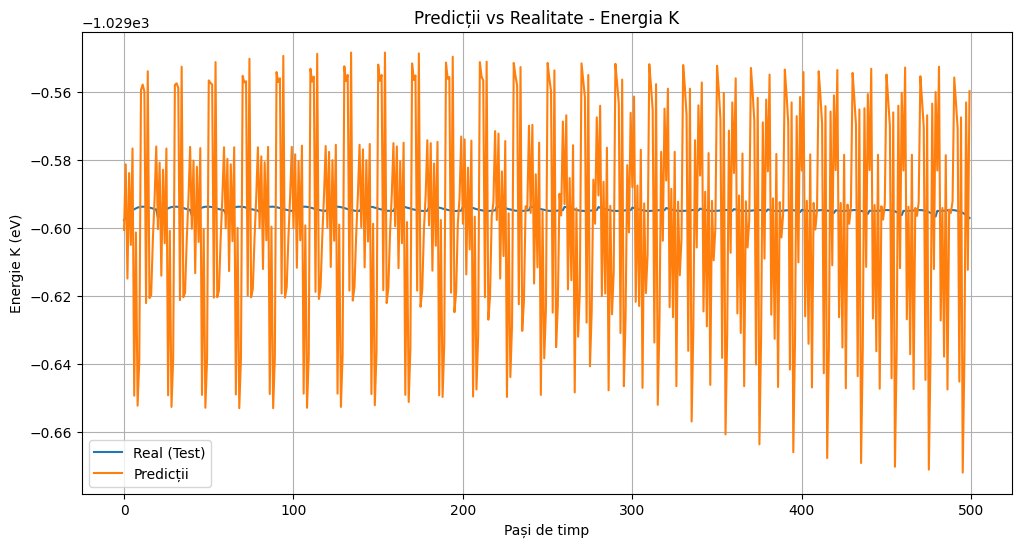

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictii pe setul de test
y_pred = model.predict(X_test, verbose=0)

# Inversare scalare pentru a reveni la valorile originale
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Calcul metrici
mse = mean_squared_error(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

# # MAPE
# mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

# Opțiune 1: MAPE cu protecție
epsilon = 1e-8
mape = np.mean(np.abs((y_test_original - y_pred_original) / (y_test_original + epsilon))) * 100

# Opțiune 2: Folosește doar MAE și RMSE pentru valori mici

print(f"🏆 Performanța modelului:")
print(f"   ├── MSE: {mse:.8f} eV²")
print(f"   ├── MAE: {mae:.8f} eV")
print(f"   ├── RMSE: {rmse:.8f} eV")
print(f"   ├── MAPE: {mape:.2f}%")
print(f"   └── R²: {r2:.6f} ({r2*100:.2f}%)")

print(f"\n📏 Context E_KS:")
print(f"   ├── Range: [{y_test_original.min():.6f}, {y_test_original.max():.6f}] eV")
print(f"   └── Amplitudine: {y_test_original.max() - y_test_original.min():.6f} eV")

# Plot comparativ predicții vs realitate
plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:500], label='Real (Test)')
plt.plot(y_pred_original[:500], label='Predicții')
plt.title('Predicții vs Realitate - Energia K')
plt.xlabel('Pași de timp')
plt.ylabel('Energie K (eV)')
plt.legend()
plt.grid(True)
plt.show()

# Salvare model final
# model.save('final_lstm_model.keras')
# print("Modelul a fost salvat ca 'final_lstm_model.keras'")


421/421 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step
(13468, 20) (13468, 200, 4) (13468, 20)
(269360, 1) (269360, 1)


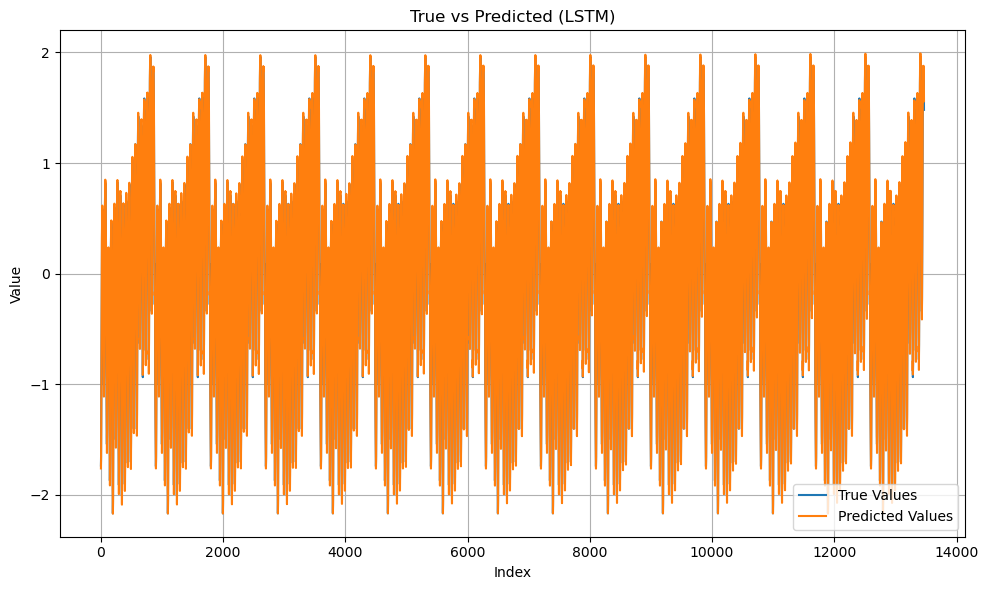

In [ ]:
import matplotlib.pyplot as plt

# Predicții
predictions = model.predict(X_test)
print(predictions.shape, X_test.shape, y_test.shape)

# Inversare scaling (dacă folosești scaler pe ieșire)
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_inverted = scaler.inverse_transform(predictions.reshape(-1, 1))
print(predictions_inverted.shape, y_test_inverted.shape)

# Grafic True vs Predicted pentru prima valoare din fiecare fereastra
plt.figure(figsize=(10, 6))
plt.plot(y_test[:, 0], label='True Values')
plt.plot(predictions[:, 0], label='Predicted Values')
plt.title('True vs Predicted (LSTM)')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


🏆 Performanța modelului (date normalizate):
   ├── MSE: 0.00942866
   ├── MAE: 0.07072285
   ├── RMSE: 0.09710131
   ├── MAPE: 49.15%
   └── R²: 0.990559 (99.06%)


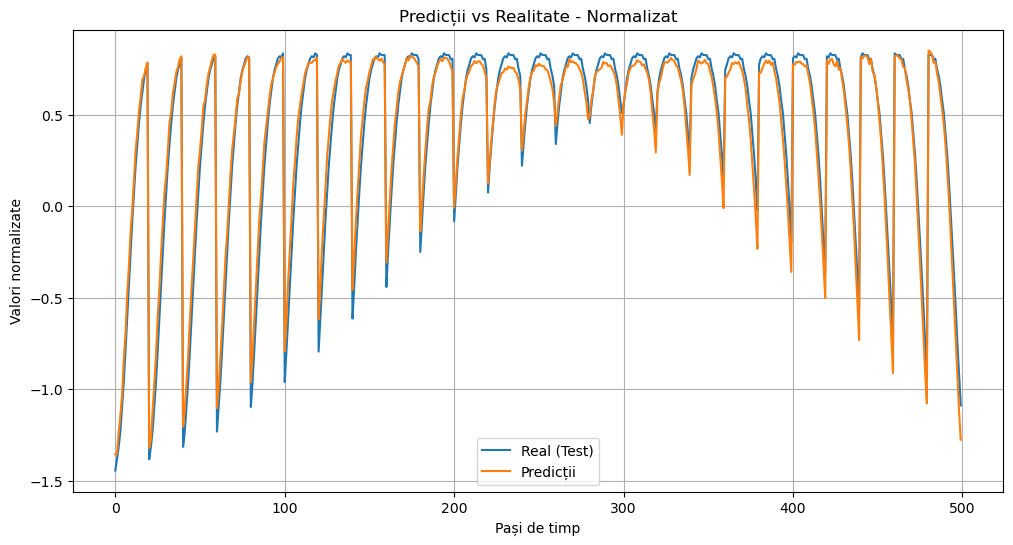

In [ ]:
# Predictii pe setul de test (date normalizate)
y_pred_norm = model.predict(X_test, verbose=0).flatten()
y_test_norm = y_test.flatten()

# Calcul metrici pe valori normalizate
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
rmse_norm = np.sqrt(mse_norm)
r2_norm = r2_score(y_test_norm, y_pred_norm)
mape_norm = np.mean(np.abs((y_test_norm - y_pred_norm) / y_test_norm)) * 100

print(f"   Performanța modelului (date normalizate):")
print(f"   ├── MSE: {mse_norm:.8f}")
print(f"   ├── MAE: {mae_norm:.8f}")
print(f"   ├── RMSE: {rmse_norm:.8f}")
print(f"   ├── MAPE: {mape_norm:.2f}%")
print(f"   └── R²: {r2_norm:.6f} ({r2_norm*100:.2f}%)")

# Plot pe date normalizate
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[:500], label='Real (Test)')
plt.plot(y_pred_norm[:500], label='Predicții')
plt.title('Predicții vs Realitate - Normalizat')
plt.xlabel('Pași de timp')
plt.ylabel('Valori normalizate')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
import plotly.graph_objects as go

# Predictii pe test set și inversare scalare
y_pred = model.predict(X_test, verbose=0)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_test_original,
    mode='lines',
    name='True Values'
))
fig.add_trace(go.Scatter(
    y=y_pred_original,
    mode='lines',
    name='Predicted Values'
))

fig.update_layout(
    title='Predicții vs Realitate - Energia K-Tot (LSTM)',
    xaxis_title='Index',
    yaxis_title='Energie (eV)'
)

# Salvează și afișează graficul în browser
fig.write_html("test_lstm_full.html", auto_open=True)
fig.show(renderer="browser")


In [26]:
import plotly.graph_objects as go

# Predictii pe test set și inversare scalare
y_pred = model.predict(X_test, verbose=0)
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Alege intervalul dorit
start_idx = 100   # index de start
end_idx = 1100    # index de final

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_test_original[start_idx:end_idx],
    mode='lines+markers',
    name='True Values'
))
fig.add_trace(go.Scatter(
    y=y_pred_original[start_idx:end_idx],
    mode='lines+markers',
    name='Predicted Values'
))

fig.update_layout(
    title=f'Predicții vs Realitate - Energia K (LSTM) [Index {start_idx}–{end_idx}]',
    xaxis_title='Index',
    yaxis_title='Energie (eV)'
)

# Salvează și afișează graficul în browser
fig.write_html("test_lstm_interval.html", auto_open=True)
fig.show(renderer="browser")
